# Homework 4

In [73]:
from typing import Tuple

import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import roc_auc_score, precision_recall_curve
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
import numpy as np


In [74]:
df = pd.read_csv('./data/data.csv')

In [75]:
df.card.value_counts()

yes    1023
no      296
Name: card, dtype: int64

In [76]:
df.head()

,card,reports,age,income,share,expenditure,owner,selfemp,dependents,months,majorcards,active
0,yes,0,37.66667,4.5200,0.033270,124.983300,yes,no,3,54,1,12
1,yes,0,33.25000,2.4200,0.005217,9.854167,no,no,3,34,1,13
2,yes,0,33.66667,4.5000,0.004156,15.000000,yes,no,4,58,1,5
3,yes,0,30.50000,2.5400,0.065214,137.869200,no,no,0,25,1,7
4,yes,0,32.16667,9.7867,0.067051,546.503300,yes,no,2,64,1,5


In [77]:
def str_to_int(value: str) -> int:
    return 1 if value == "yes" else 0

df.card = df.card.map(str_to_int)

In [78]:
full_train, test = train_test_split(df, train_size=0.8, random_state=1)
train, val = train_test_split(full_train, train_size=0.75, random_state=1)

full_train = full_train.reset_index(drop=True)
train = train.reset_index(drop=True)
val = val.reset_index(drop=True)
test = test.reset_index(drop=True)

len(train.index), len(val.index), len(test.index)

(791, 264, 264)

## Question 1

In [79]:
print(f"{'feature:' : <15} {'auc:': >10}")
for feature in train.columns[1:]:
    if train.dtypes[feature] != 'object':
        if roc_auc_score(train.card, train[feature]) > 0.5:
            print(f'{feature: <15} {round(roc_auc_score(train.card, train[feature]), 4) : >10}')
        else: 
            print(f'{feature: <15} {round(roc_auc_score(train.card, -train[feature]), 4) : >10}')

feature:              auc:
reports             0.7167
age                  0.524
income              0.5908
share               0.9892
expenditure          0.991
dependents          0.5328
months              0.5294
majorcards          0.5344
active              0.6043


Share has the highest AUC score.

## Question 2

In [80]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [81]:
train_y = train.card
train = train[features]

val_y = val.card
val = val[features]

test_y = test.card
test = test[features]

In [82]:
dv = DictVectorizer(sparse=False)
train_X = dv.fit_transform(train.to_dict(orient='records'))
val_X = dv.transform(val.to_dict(orient='records'))
test_X = dv.transform(test.to_dict(orient='records'))

In [83]:
lr = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
lr.fit(train_X, train_y)

val_pred = lr.predict_proba(val_X)

round(roc_auc_score(val_y, val_pred[:,1]),3)

0.995

## Question 3, 4

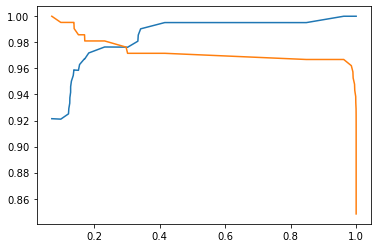

In [84]:
precision, recall, threshold = precision_recall_curve(val_y, val_pred[:,1])

plt.plot(threshold, precision[:-1])
plt.plot(threshold, recall[:-1])
plt.show()

0.9832134292565947
0.415690744186498


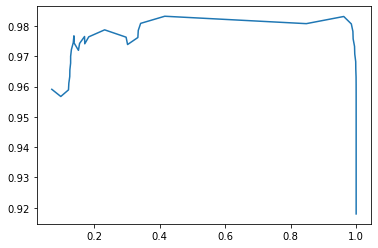

In [85]:
F_1 = []

for p, r in zip(precision, recall):
    F_1.append(2*p*r/(p+r))
    
idx = np.argmax(F_1)
print(F_1[idx])
print(threshold[idx])
    
plt.plot(threshold, F_1[:-1])

Precision and recall intersect at 0.3.
F_1 is max at 0.4.

## Question 5

In [87]:

def vectorize(train_X: pd.DataFrame, val_X: pd.DataFrame) -> tuple[np.array]:
    dv = DictVectorizer(sparse=False)
    train_X = dv.fit_transform(train_X.to_dict(orient='records'))
    val_X = dv.transform(val_X.to_dict(orient='records'))
    
    return train_X, val_X
    
    
def split_X_y(dataset: pd.DataFrame, features: list[str]) -> tuple[pd.DataFrame, np.array]:
    dataset_y = dataset.card.values
    del dataset['card']
    dataset_X = dataset[features]
    
    return dataset_X, dataset_y


def train(train_X: np.array, train_y: np.array, C:float =1.0) -> LogisticRegression:
    lr = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    lr.fit(train_X, train_y)
    
    return lr
    

def predict(val_X: np.array, lr: LogisticRegression) -> np.array:
    
    return lr.predict_proba(val_X)[:,1]


def cross_validate(full_train: pd.DataFrame, C_values: list[int]=[1.0]):
    
    auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=1)

    for C in C_values:
        
        auc = []
        for train_idx, val_idx in kf.split(full_train):
            train_df = full_train.iloc[train_idx]
            val_df = full_train.iloc[val_idx]

            train_X, train_y = split_X_y(train_df, features)
            val_X, val_y = split_X_y(val_df, features)

            train_X, val_X = vectorize(train_X, val_X)


            model = train(train_X, train_y, C)
            probs = predict(val_X, model)

            auc.append(roc_auc_score(val_y, probs))
            
        auc_scores.append({'C': C, 'mean': np.mean(auc), 'std': np.std(auc)})
        
    return auc_scores
    
    

In [88]:
score = cross_validate(full_train)[0]
print(f"standard deviation on auc: {round(score['std'], 3)}")

standard deviation on auc: 0.003


## Question 6

In [92]:
scores = cross_validate(full_train, C_values=[0.01, 0.1, 1, 10])

pd.DataFrame(scores).round(3)

,C,mean,std
0,0.01,0.992,0.006
1,0.10,0.995,0.004
2,1.00,0.996,0.003
3,10.00,0.996,0.003


C=1.00